# Dolfinh5tools tutorial

Updated: 16 October 2015
Author: Marijan Beg

This tutorial demonstates the use of dolfinh5tools for saving data obtained using FEniCS.

The time dependent heat equation is used.

## Saving data

Firstly, the time-dependent heat equation problem is defined (courtesy of Fenics project http://fenicsproject.org/pub/course/lectures/2012-06-29-rognes-imperial-uk/lecture_04_time_dependent_pdes.pdf)

In [1]:
# Time dependent heat equation.
from fenics import *

# Create mesh and define function space
mesh = UnitSquareMesh(5, 5)
V = FunctionSpace(mesh, 'Lagrange', 1)

# Define initial condition expression g (will also be used as boundary
# condition), and interpolate into initial function u0
alpha = 3.0
beta = 1.2
g = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
               alpha=alpha, beta=beta, t=0, degree=2)
u0 = interpolate(g, V)

# Define boundary condition
bc = DirichletBC(V, g, "on_boundary")

# Define timestep and end-time
dt = 0.2
T = 1.8

# Define variational problem for each time-step
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)
a = u*v*dx + dt*inner(grad(u), grad(v))*dx
L = (u0 + dt*f)*v*dx

# Assemble once before the time-stepping begins
A = assemble(a)

# Define function for unknown at this time step
u1 = Function(V)

t = dt

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


Now, the savingdata module is imported, files to which the data would be saved are created, and the mesh is saved.

In [2]:
# Import dolfinh5tools
from lib import openh5

# Create a saving object.
h5file = openh5('heat_equation_data', functionspace=V, mode='w')

# Save mesh to h5 file.
h5file.save_mesh(name='mesh')

Debug: (0/1) opening file heat_equation_data.h5
Debug: (0/1) writing json file heat_equation_data.json


Two files are created.

In [3]:
!ls *.h5 *.json

heat_equation_data.h5  heat_equation_data.json


Now, the data is saved at every time step.

In [4]:
while t <= T:
    print 'Time: ', t
    # Assemble right-hand side vector
    b = assemble(L)

    # Update and apply boundary condition
    g.t = t
    bc.apply(A, b)

    # Solve linear system of equations
    solve(A, u1.vector(), b)
    
    # Save data in u1 at time step t.
    h5file.write(u0, field_name='u', t=t)
    
    # Update time and previous function
    t += dt
    u0.assign(u1)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


Time:  0.2
Debug: (0/1) writing json file heat_equation_data.json
Time:  0.4
Debug: (0/1) writing json file heat_equation_data.json
Time:  0.6
Debug: (0/1) writing json file heat_equation_data.json
Time:  0.8
Debug: (0/1) writing json file heat_equation_data.json
Time:  1.0
Debug: (0/1) writing json file heat_equation_data.json
Time:  1.2
Debug: (0/1) writing json file heat_equation_data.json
Time:  1.4
Debug: (0/1) writing json file heat_equation_data.json
Time:  1.6
Debug: (0/1) writing json file heat_equation_data.json
Time:  1.8
Debug: (0/1) writing json file heat_equation_data.json


After the saving is completed, the hf file is closed.

In [6]:
h5file.close()

## Loading data from the saved h5 file.

The data can be loaded using the loading object at any time steps that was previously saved. The loaded data is plotted along $y=5$ line.

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


Saved fields:  [u'u']
Times at which the field was saved:  [0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2, 1.4, 1.5999999999999999, 1.7999999999999998]


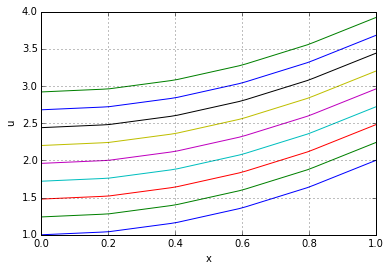

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create a loading object.
h5file = openh5('heat_equation_data', mode='r')

# Load the mesh.
mesh = h5file.load_mesh(name='mesh')

# Get field names and times at which they were saved.
fields_list = h5file.fields()
print 'Saved fields: ', fields_list

t_list = h5file.times(field_name='u')
print 'Times at which the field was saved: ', t_list

def plot_along_line(u, xmin=0, xmax=1):
    x_array = np.linspace(0, 1, 50)
    u_values = []
    for x in x_array:
        u_values.append(u(x, 0))
        
    plt.plot(x_array, u_values)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.grid()
    
for t in t_list:
    # Load the field.
    u = h5file.read(t=t, field_name='u')
    plot_along_line(u)